# DEMAND FORECASTING FOR SKU3

* IMPORTING LIBRARIES


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

* DATA LOADING

In [43]:
import pandas as pd
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU3')
df = df.set_index('Date of Invoice').sort_index()

* CHECKING FOR MISSING DATES

In [44]:
 # Create a full list of all dates from the first to the last date in your dataset, with daily frequency
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Find the dates that are in 'full_range' but NOT in your actual DataFrame index
missing_dates = full_range.difference(df.index)

# Print how many dates are missing in total
print(f"Missing Dates: {len(missing_dates)} found.")


# If there are missing dates, show the first 10 missing ones as a preview
if len(missing_dates) > 0:
    print(missing_dates[:10])
    
#  Check the difference between consecutive dates
date_diff_counts = df.index.to_series().diff().dropna().value_counts()

#  Print how often each type of date gap occurs (e.g., 1 day, 2 days, etc.)
print("\nDate Differences:")
print(date_diff_counts)

# Check if there's more than one type of date gap, or if it's not exactly 1 day
if len(date_diff_counts) > 1 or date_diff_counts.index[0] != pd.Timedelta(days=1):
    print("Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.")
else:
    print("Data is uniformly spaced by 1 day. Use `method='linear'` for interpolation.")

Missing Dates: 320 found.
DatetimeIndex(['2022-04-09', '2022-04-10', '2022-04-13', '2022-04-14',
               '2022-04-17', '2022-04-19', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26'],
              dtype='datetime64[ns]', freq=None)

Date Differences:
Date of Invoice
1 days     106
2 days      45
3 days      21
4 days      21
5 days       9
7 days       9
6 days       3
9 days       3
8 days       2
12 days      1
17 days      1
Name: count, dtype: int64
Data is not uniformly spaced by 1 day. Use `method='time'` for interpolation.


* CHECKING FOR OUTLIERS


Outliers in QTY: 37 found.
Consider using median or rolling median to smooth outlier values in QTY.


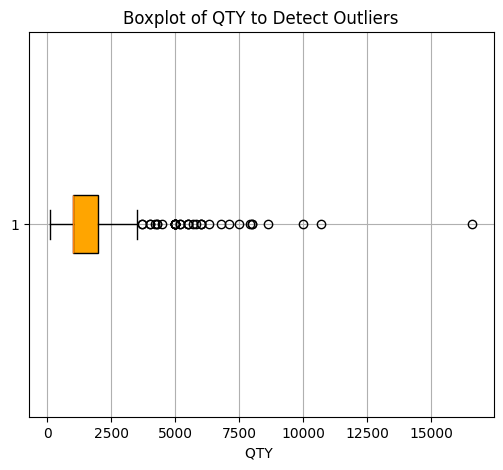

In [45]:
import matplotlib.pyplot as plt

# Your existing outlier detection
Q1 = df['QTY '].quantile(0.25)
Q3 = df['QTY '].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['QTY '] < Q1 - 1.5 * IQR) | (df['QTY '] > Q3 + 1.5 * IQR)]

print(f"\nOutliers in QTY: {len(outliers)} found.")
if len(outliers) > 0:
    print("Consider using median or rolling median to smooth outlier values in QTY.")
else:
    print("QTY data looks clean. You can use interpolation safely.")

# Plotting boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(df['QTY '], vert=False, patch_artist=True, boxprops=dict(facecolor='orange', color='black'),)
plt.title('Boxplot of QTY to Detect Outliers')
plt.xlabel('QTY ')
plt.grid(True)
plt.show()

* REINDEX AND SHOW WHAT MISSING ROWS LOOK LIKE

In [46]:
df_reindexed = df.reindex(full_range)
print("\nReindexed Data Preview (with NaNs):")
print(df_reindexed.head(10))


Reindexed Data Preview (with NaNs):
            Material No. Cat-III Desc           Cat-IV Desc    QTY   NET SALES
2022-04-07    61004148.0      4W BULB  4W BULB INCANDANSCEN  1000.0    7095.20
2022-04-08    61004148.0      4W BULB  4W BULB INCANDANSCEN   100.0     709.52
2022-04-09           NaN          NaN                   NaN     NaN        NaN
2022-04-10           NaN          NaN                   NaN     NaN        NaN
2022-04-11    61004148.0      4W BULB  4W BULB INCANDANSCEN  1000.0    7095.20
2022-04-12    61004148.0      4W BULB  4W BULB INCANDANSCEN  1000.0    7095.20
2022-04-13           NaN          NaN                   NaN     NaN        NaN
2022-04-14           NaN          NaN                   NaN     NaN        NaN
2022-04-15    61004148.0      4W BULB  4W BULB INCANDANSCEN  1000.0    6360.20
2022-04-16    61004148.0      4W BULB  4W BULB INCANDANSCEN  2000.0   12720.40


* CLEANING

In [47]:
# === Load the SKU3 sheet ===
df = pd.read_excel("LUMAX_Data.xlsx", sheet_name='SKU3')

# === Clean column names ===
df.columns = df.columns.str.strip()

# === Convert date column to datetime ===
df['Date of Invoice'] = pd.to_datetime(df['Date of Invoice'])

# === Set index to date ===
df.set_index('Date of Invoice', inplace=True)

# === Reindex to fill missing days ===
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_index)
df_full.index.name = 'Date of Invoice'


# === Apply rolling median first (smooth outliers) ===
df_full['QTY_rolled'] = df_full['QTY'].rolling(window=7, center=True, min_periods=1).median()

# === Interpolate missing values after smoothing ===
df_full['QTY_rolled'] = df_full['QTY_rolled'].interpolate(method='time').round().astype('Int64')

# === Forward-fill static info (Material No.) ===
df_full['Material No.'] = df_full['Material No.'].ffill().astype('Int64')

# === Reset index for resampling ===
df_full = df_full.reset_index()

# === Drop unneeded columns if present ===
df_cleaned = df_full.drop(columns=['Cat-III Desc', 'Cat-IV Desc', 'NET SALES'], errors='ignore')

# === Resample to weekly demand (week ending on Monday) ===
df_weekly = df_cleaned.resample('W-Mon', on='Date of Invoice').sum(numeric_only=True)['QTY_rolled'].reset_index()

# === Preview cleaned weekly data ===
print(df_weekly.head())

  Date of Invoice  QTY_rolled
0      2022-04-11        4550
1      2022-04-18       10500
2      2022-04-25       15500
3      2022-05-02        8500
4      2022-05-09        5000


* PLOTTING WEEKLY DEMAND

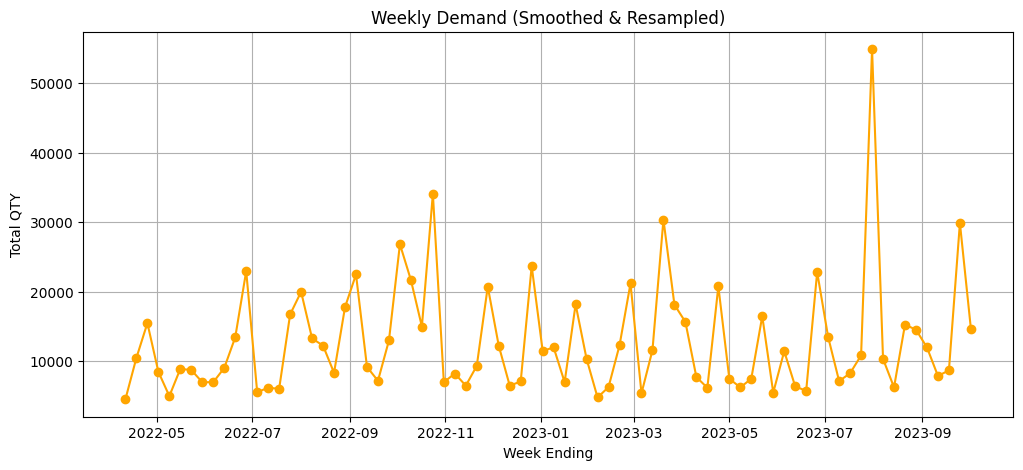

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# === Plot weekly demand ===
plt.figure(figsize=(12, 5))
plt.plot(df_weekly['Date of Invoice'], df_weekly['QTY_rolled'], marker='o',color='orange')
plt.title('Weekly Demand (Smoothed & Resampled)')
plt.xlabel('Week Ending')
plt.ylabel('Total QTY') 
plt.grid(True)
plt.show()

The seasonal variations change with the level of total quantity, so a multiplicative model is appropriate.

* PLOTTING GRAPH OF BOX-COX & LOG TRANSFORMATION

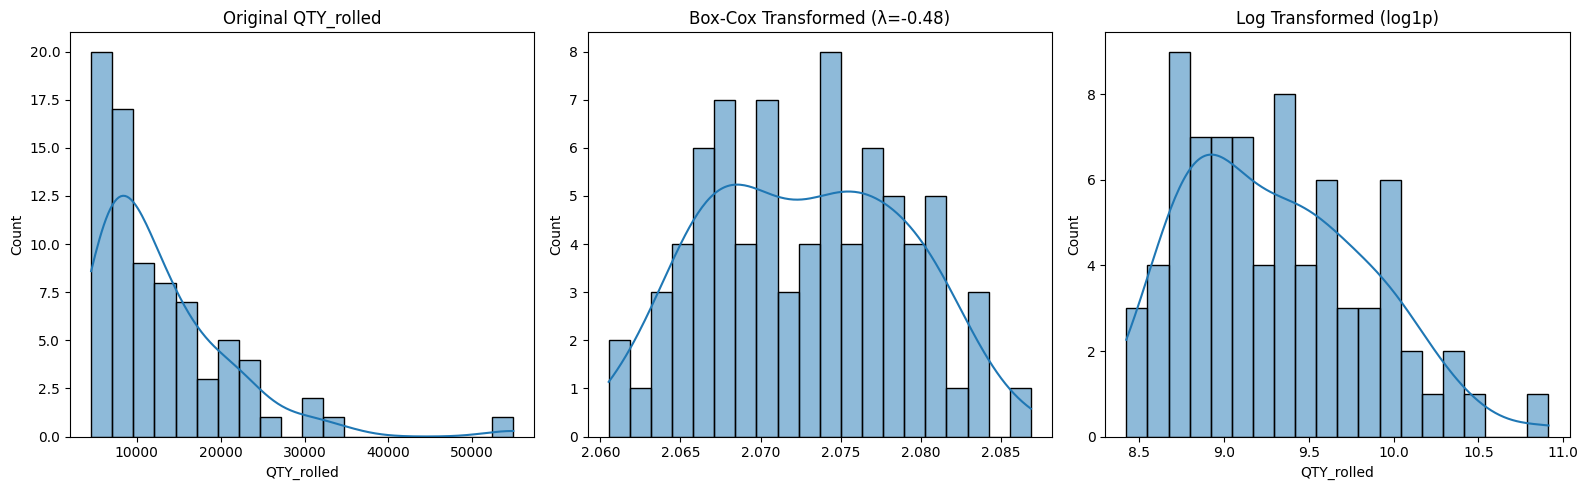

In [49]:
# Drop NaNs and non-positive values
qty = df_weekly['QTY_rolled'].dropna()
qty = qty[qty > 0]

# Box-Cox transformation
qty_boxcox, lmbda = boxcox(qty)
# Store the transformed series in your DataFrame
df_weekly['QTY_boxcox'] = qty_boxcox

# Log transformation (optional)
qty_log = np.log1p(qty)  # log1p handles zero values safely
df_weekly['QTY_log'] = qty_log

# Plotting
plt.figure(figsize=(16, 5))

# Original
plt.subplot(1, 3, 1)
sns.histplot(qty, kde=True, bins=20)
plt.title("Original QTY_rolled")

# Box-Cox
plt.subplot(1, 3, 2)
sns.histplot(qty_boxcox, kde=True, bins=20)
plt.title(f"Box-Cox Transformed (λ={lmbda:.2f})")

# Log Transformed
plt.subplot(1, 3, 3)
sns.histplot(qty_log, kde=True, bins=20)
plt.title("Log Transformed (log1p)")

plt.tight_layout()
plt.show()

* STL DECOMPOSITION

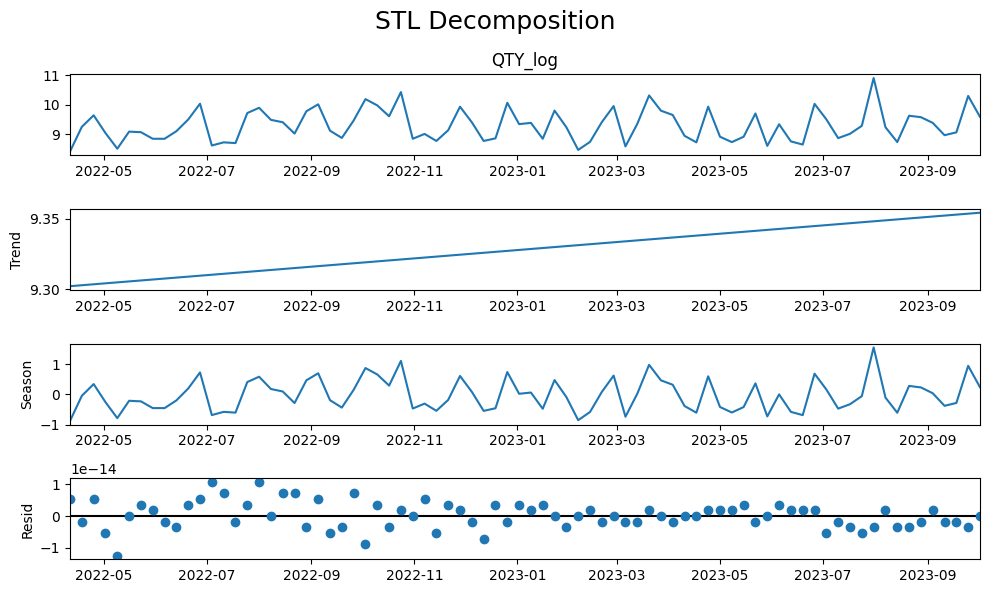

In [50]:
#STL Decomposition
from statsmodels.tsa.seasonal import STL
df_weekly.set_index('Date of Invoice', inplace=True)

# STL expects a datetime index with frequency
df_weekly.index = pd.to_datetime(df_weekly.index)
df_weekly = df_weekly.asfreq('W-MON')

# STL Decomposition (seasonal_period=53 closer to 52 for weekly data)
stl = STL(df_weekly['QTY_log'], seasonal=53)
result = stl.fit()

# Plot the components
fig = result.plot()
fig.set_size_inches(10, 6)
plt.suptitle("STL Decomposition", fontsize=18)
plt.tight_layout()
plt.show()

* ADF TEST FOR CHECKING STATIONARITY


ADF Test for Differencing Level: 0
ADF Statistic: -7.9169694753187905
p-value: 3.8132170447432164e-12
Critical Value (1%): -3.5194805351545413
Critical Value (5%): -2.9003945086747343
Critical Value (10%): -2.5874984279778395

The series is stationary (reject null hypothesis)

Total differencing applied: 0


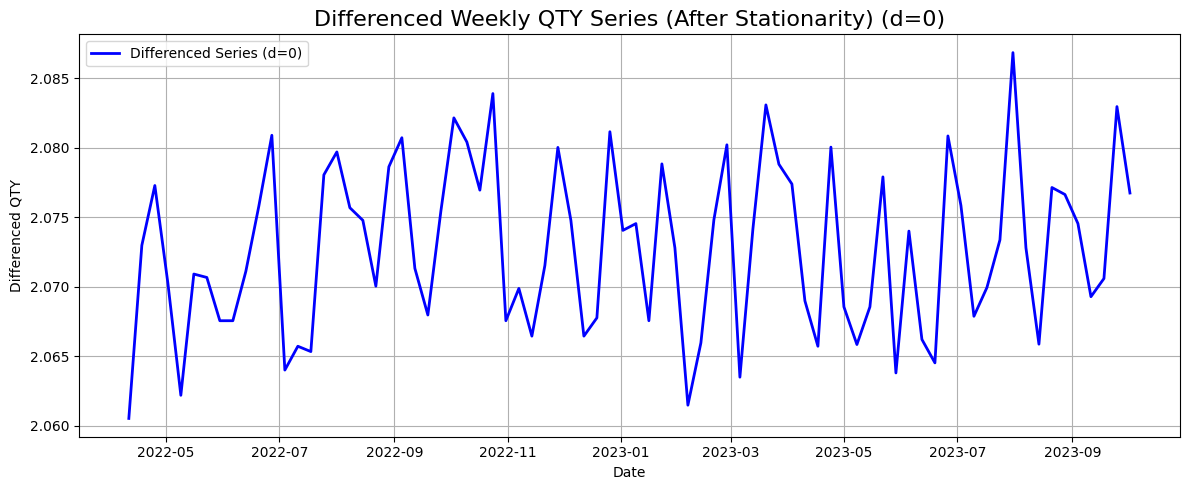

In [51]:
diff_series = df_weekly['QTY_boxcox'].copy()
d = 0  # Differencing counter

while True:
    print(f"\nADF Test for Differencing Level: {d}")
    result = adfuller(diff_series.dropna())

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")

    if result[1] < 0.05:
        print("\nThe series is stationary (reject null hypothesis)")
        break
    else:
        print("The series is non-stationary, applying differencing...")
        diff_series = diff_series.diff().dropna()
        d += 1

print(f"\nTotal differencing applied: {d}")

# Plotting the differenced series
plt.figure(figsize=(12, 5))
plt.plot(diff_series, color='blue', linewidth=2, label=f'Differenced Series (d={d})')
plt.title(f'Differenced Weekly QTY Series (After Stationarity) (d={d})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Differenced QTY')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


* ACF AND PACF PLOTS

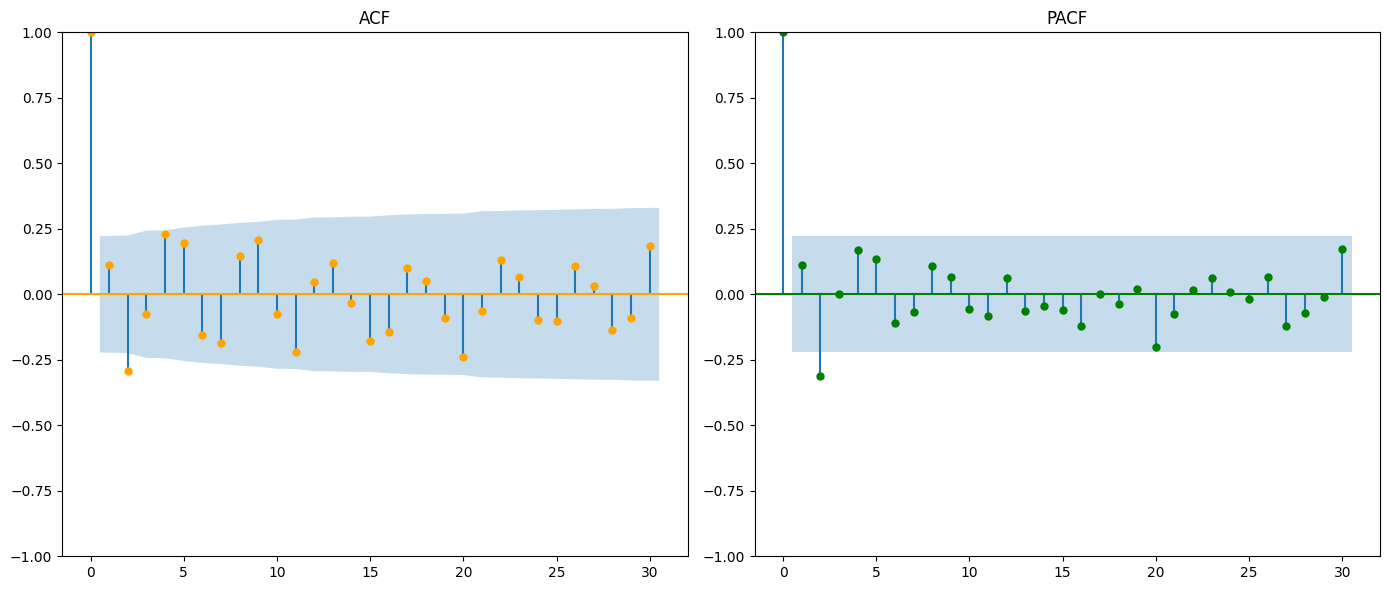

In [52]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=30, ax=plt.gca(),color='orange')
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=30, ax=plt.gca(), method='ywm',color='green')
plt.title('PACF')

plt.tight_layout()
plt.show()

* CHECKING FOR WHITE NOISE BY LJUNG-BOX TEST

In [53]:
# Apply Ljung-Box test on the differenced series
ljung_box_result = acorr_ljungbox(diff_series.dropna(), lags=[10], return_df=True)

print("Ljung-Box Test Result:")
print(ljung_box_result)

# Interpretation
p_value = ljung_box_result['lb_pvalue'].values[0]

if p_value > 0.05:
    print("\nThe series appears to be white noise (p-value > 0.05).")
    print("→ It has no predictable structure. Forecasting may not be meaningful.")
else:
    print("\nThe series is NOT white noise (p-value <= 0.05).")
    print("→ It has autocorrelation and structure that can be modeled.")

Ljung-Box Test Result:
      lb_stat  lb_pvalue
10  27.803253   0.001941

The series is NOT white noise (p-value <= 0.05).
→ It has autocorrelation and structure that can be modeled.


* TRAIN-TEST SPLIT,LOG TRANSFORMATION,MODEL EVALUATION

In [54]:
from statsmodels.tsa.seasonal import STL
warnings.filterwarnings("ignore")

train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled']
y_test = test['QTY_rolled']

# Handle zero or negative values in the data before log transformation
y_train_clean = y_train.copy()
y_test_clean = y_test.copy()

# Replace zero or negative values with small positive values
y_train_clean[y_train_clean <= 0] = 1e-6
y_test_clean[y_test_clean <= 0] = 1e-6

# Log-transform train and test series
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_clean)

#  ADD STL DECOMPOSITION
stl = STL(y_train_log, period=52, robust=True)   # 52 weeks = annual seasonality
res = stl.fit()

best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}

Naive - MAPE: 43.01%
Moving Average - MAPE: 38.33%
SES - MAPE: 38.21%
Holt Linear - MAPE: 38.43%
Holt-Winters - MAPE: 21.81%
ARIMA - MAPE: 35.78%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=549.476, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=121.006, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.254, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=121.337, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=121.414, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.598 seconds
Auto-ARIMA - MAPE: 38.21%
SARIMA - MAPE: 28.23%

 No method achieved MAPE < 10%


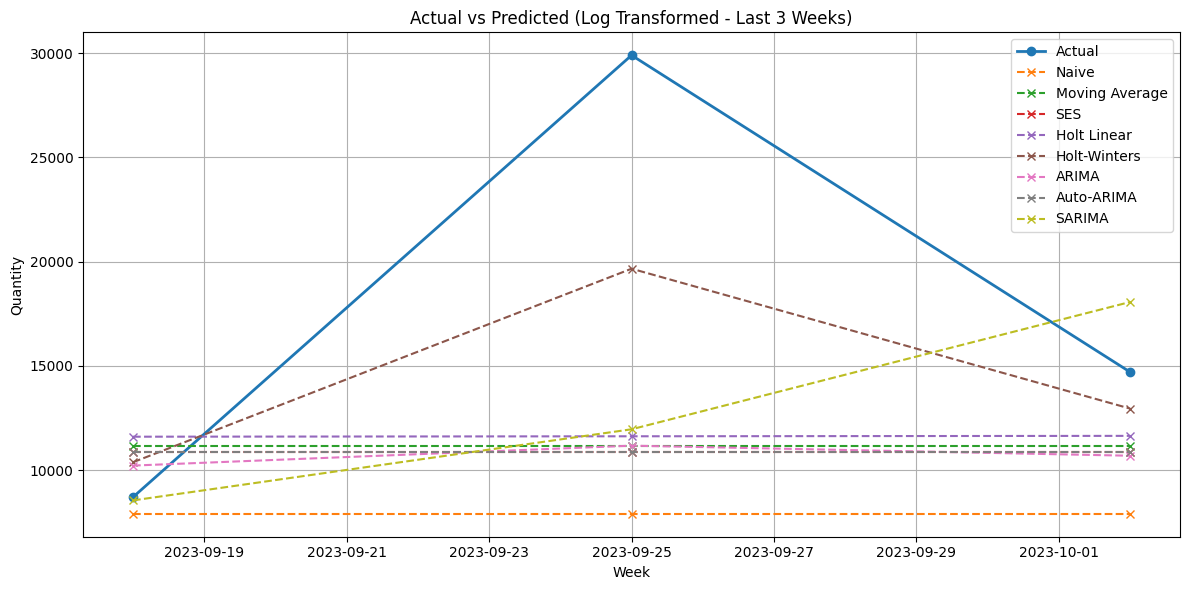

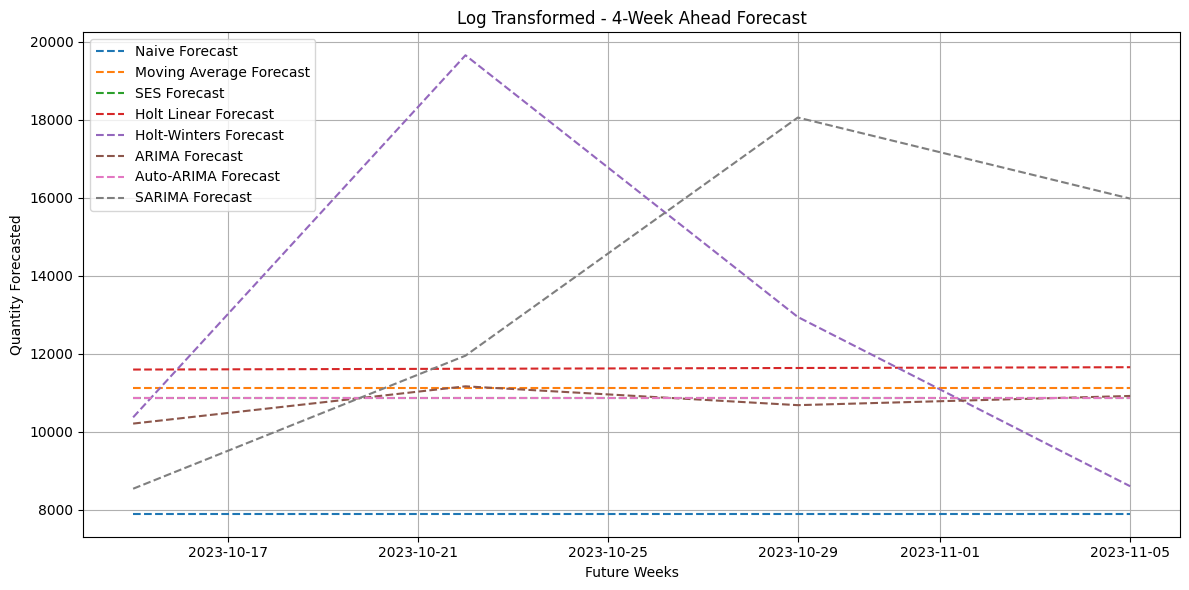


4-Week Forecast by Best Model (Holt-Winters):
2023-09-18    10374
2023-09-25    19659
2023-10-02    12947
2023-10-09     8607
Freq: W-MON, dtype: int32


In [55]:
def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        # Inverse transformation
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Models

# Naive model
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average model
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# Simple Exponential Smoothing (SES)
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    ses_test = ses_model.forecast(3)
    ses_future = ses_model.forecast(4)
    evaluate_model("SES", ses_test, ses_future)
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    holt_test = holt_model.forecast(3)
    holt_future = holt_model.forecast(4)
    evaluate_model("Holt Linear", holt_test, holt_future)
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    hw_test = hw_model.forecast(3)
    hw_future = hw_model.forecast(4)
    evaluate_model("Holt-Winters", hw_test, hw_future)
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,1)).fit()
    arima_test = arima_model.forecast(3)
    arima_future = arima_model.forecast(4)
    evaluate_model("ARIMA", arima_test, arima_future)
except Exception as e:
    print("ARIMA - Error:", e)

# Auto-ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    auto_test = auto_model.predict(n_periods=3)
    auto_future = auto_model.predict(n_periods=4)
    evaluate_model("Auto-ARIMA", auto_test, auto_future)
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52)).fit()
    sarima_test = sarima_model.forecast(3)
    sarima_future = sarima_model.forecast(4)
    evaluate_model("SARIMA", sarima_test, sarima_future)
except Exception as e:
    print("SARIMA - Error:", e)

# Output best method
if best_mape < 0.10:
    print(f"\n Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Log Transformed - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot next 4-week forecasts
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Log Transformed - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")

* MODEL TRAINING,EVALUATION (MAPE BASED),AND FORECASTING WITH INVERSE  LOG TRANSFORMATION

Naive - MAPE: 43.01%
Moving Average - MAPE: 38.33%
SES - MAPE: 38.21%
Holt Linear - MAPE: 38.43%
Holt-Winters - MAPE: 21.81%
ARIMA - MAPE: 35.78%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=549.476, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=121.006, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.254, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=121.337, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=121.414, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.604 seconds
Auto-ARIMA - MAPE: 38.21%
SARIMA - MAPE: 28.23%

 No method achieved MAPE < 10%


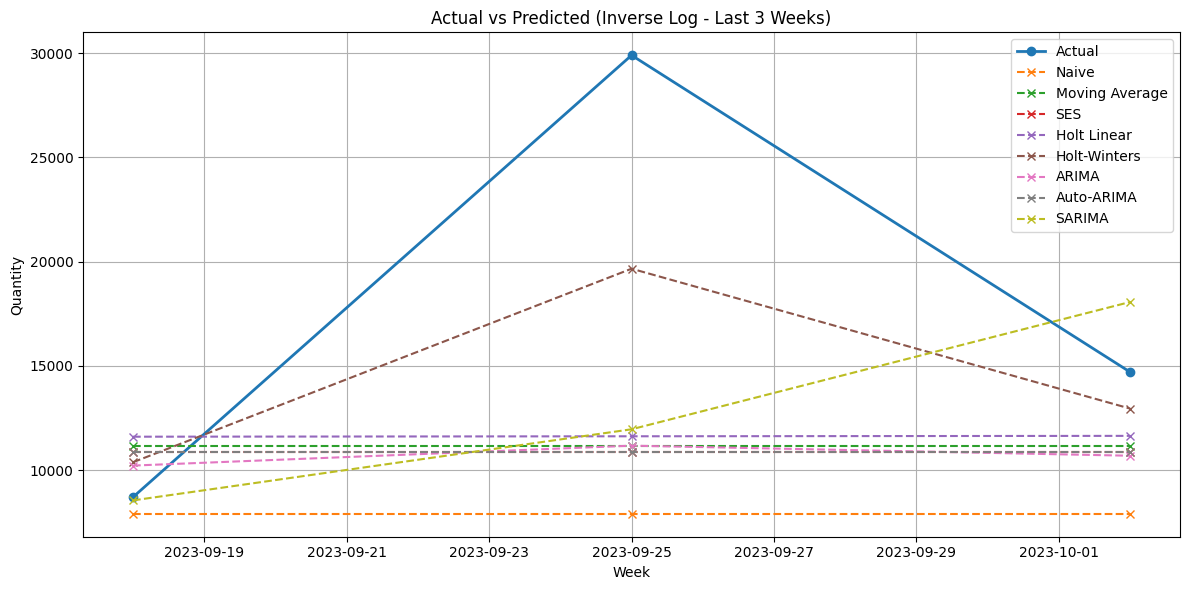

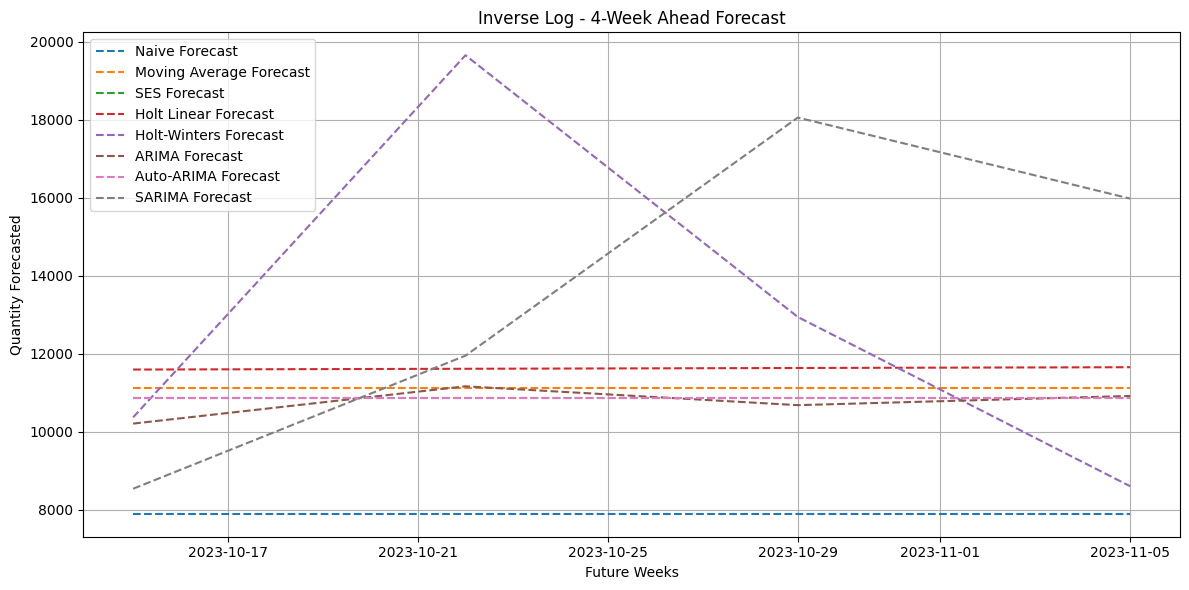


4-Week Forecast by Best Model (Holt-Winters):
2023-09-18    10374
2023-09-25    19659
2023-10-02    12947
2023-10-09     8607
Freq: W-MON, dtype: int32


In [56]:
# train = df_weekly[:-3]
# test = df_weekly[-3:]
# y_train = train['QTY_boxcox']
# y_test = test['QTY_boxcox']
# best_method = None
# best_mape = float('inf')

# test_forecasts = {}
# forecast_4weeks = {}

# # Store fitted lambda used for boxcox
# fitted_lambda = lmbda 

# def evaluate_model(name, forecast_test, forecast_future):
#     global best_method, best_mape
#     try:
#         mape = mean_absolute_percentage_error(y_test, forecast_test)
#         results[name] = mape
#         test_forecasts[name] = forecast_test
#         forecast_4weeks[name] = forecast_future
#         if mape < best_mape:
#             best_mape = mape
#             best_method = name
#         print(f"{name} - MAPE: {mape * 100:.2f}%")
#     except Exception as e:
#         print(f"{name} - Error: {e}")

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Prepare data
train = df_weekly[:-3]
test = df_weekly[-3:]
y_train = train['QTY_rolled']
y_test = test['QTY_rolled']

# Replace zero or negative values before log transformation
y_train[y_train <= 0] = 1e-6
y_test[y_test <= 0] = 1e-6

# Log transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# STL decomposition
stl = STL(y_train_log, period=52, robust=True)
res = stl.fit()

# Initialize
best_method = None
best_mape = float('inf')
results = {}
forecast_4weeks = {}
test_forecasts = {}

# Evaluation function with inverse-log transformation
def evaluate_model(name, forecast_test_log, forecast_future_log):
    global best_method, best_mape
    try:
        forecast_test = np.round(np.expm1(forecast_test_log)).astype(int)
        forecast_future = np.round(np.expm1(forecast_future_log)).astype(int)
        actual_test = np.round(np.expm1(y_test_log)).astype(int)

        mape = mean_absolute_percentage_error(actual_test, forecast_test)
        results[name] = mape
        test_forecasts[name] = forecast_test
        forecast_4weeks[name] = forecast_future

        if mape < best_mape:
            best_mape = mape
            best_method = name
        print(f"{name} - MAPE: {mape * 100:.2f}%")
    except Exception as e:
        print(f"{name} - Error: {e}")

# Naive
try:
    naive_test = [y_train_log.iloc[-1]] * 3
    naive_future = [y_train_log.iloc[-1]] * 4
    evaluate_model("Naive", naive_test, naive_future)
except Exception as e:
    print("Naive - Error:", e)

# Moving Average
try:
    ma_test = [y_train_log[-3:].mean()] * 3
    ma_future = [y_train_log[-3:].mean()] * 4
    evaluate_model("Moving Average", ma_test, ma_future)
except Exception as e:
    print("Moving Average - Error:", e)

# SES
try:
    ses_model = SimpleExpSmoothing(y_train_log).fit()
    evaluate_model("SES", ses_model.forecast(3), ses_model.forecast(4))
except Exception as e:
    print("SES - Error:", e)

# Holt Linear
try:
    holt_model = Holt(y_train_log).fit()
    evaluate_model("Holt Linear", holt_model.forecast(3), holt_model.forecast(4))
except Exception as e:
    print("Holt Linear - Error:", e)

# Holt-Winters
try:
    hw_model = ExponentialSmoothing(y_train_log, seasonal='mul', seasonal_periods=13).fit()
    evaluate_model("Holt-Winters", hw_model.forecast(3), hw_model.forecast(4))
except Exception as e:
    print("Holt-Winters - Error:", e)

# ARIMA
try:
    arima_model = ARIMA(y_train_log, order=(1,0,1)).fit()
    evaluate_model("ARIMA", arima_model.forecast(3), arima_model.forecast(4))
except Exception as e:
    print("ARIMA - Error:", e)

# Auto ARIMA
try:
    auto_model = auto_arima(y_train_log, seasonal=False, stepwise=True, trace=True)
    evaluate_model("Auto-ARIMA", auto_model.predict(n_periods=3), auto_model.predict(n_periods=4))
except Exception as e:
    print("Auto-ARIMA - Error:", e)

# SARIMA
try:
    sarima_model = SARIMAX(y_train_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52)).fit()
    evaluate_model("SARIMA", sarima_model.forecast(3), sarima_model.forecast(4))
except Exception as e:
    print("SARIMA - Error:", e)

# Print Best Method
if best_mape < 0.10:
    print(f"\n Best method: {best_method} with MAPE: {best_mape * 100:.2f}%")
else:
    print("\n No method achieved MAPE < 10%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, np.expm1(y_test_log), label="Actual", marker='o', linewidth=2)
for name, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=f"{name}", linestyle='--', marker='x')
plt.title("Actual vs Predicted (Inverse Log - Last 3 Weeks)")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot future forecast
plt.figure(figsize=(12, 6))
future_index = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
for name, forecast in forecast_4weeks.items():
    plt.plot(future_index, forecast, label=f"{name} Forecast", linestyle='--')
plt.title("Inverse Log - 4-Week Ahead Forecast")
plt.xlabel("Future Weeks")
plt.ylabel("Quantity Forecasted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show best model's 4-week forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")


In [57]:
# # Naive Forecast
# try:
#     naive_test = [y_train.iloc[-1]] * 3
#     naive_future = [y_train.iloc[-1]] * 4
#     evaluate_model("Naive", naive_test, naive_future)
# except Exception as e:
#     print("Naive - Error:", e)

# # 2. Moving Average
# try:
#     ma_test = [y_train[-3:].mean()] * 3
#     ma_future = [y_train[-3:].mean()] * 4
#     evaluate_model("Moving Average", ma_test, ma_future)
# except Exception as e:
#     print("Moving Average - Error:", e)

# # Simple Exponential Smoothing
# try:
#     ses_model = SimpleExpSmoothing(y_train).fit()
#     ses_forecast = ses_model.forecast(3)
#     ses_future = ses_model.forecast(4)
#     evaluate_model("SES", ses_forecast, ses_future)
# except Exception as e:
#     print("SES - Error:", e)

# # Holt’s Linear Trend
# try:
#     holt_model = Holt(y_train).fit()
#     holt_forecast = holt_model.forecast(3)
#     holt_future = holt_model.forecast(4)
#     evaluate_model("Holt Linear", holt_forecast,holt_future)
# except Exception as e:
#     print("Holt Linear - Error:", e)

# # Holt-Winters Seasonal
# try:
#     hw_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=13).fit()
#     hw_forecast = hw_model.forecast(3)
#     hw_future = hw_model.forecast(4)
#     evaluate_model("Holt-Winters", hw_forecast, hw_future)
# except Exception as e:
#     print("Holt-Winters - Error:", e)

# # ARIMA
# try:
#     arima_model = ARIMA(y_train, order=(2,0,1)).fit()
#     arima_forecast = arima_model.forecast(3)
#     arima_future = arima_model.forecast(4)
#     evaluate_model("ARIMA", arima_forecast, arima_future)
# except Exception as e:
#     print("ARIMA - Error:", e)

# # Auto Arima
# try:
#     auto_model = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)
#     auto_test = auto_model.predict(n_periods=3)
#     auto_future = auto_model.predict(n_periods=4)
#     evaluate_model("Auto-ARIMA", auto_test, auto_future)
# except Exception as e:
#     print("ARIMA - Error:", e)   


# # SARIMA
# try:
#     sarima_model = SARIMAX(y_train, order=(2,0,1), seasonal_order=(2,0,1,52)).fit()
#     sarima_forecast = sarima_model.forecast(3)
#     sarima_future = sarima_model.forecast(4)
#     evaluate_model("SARIMA", sarima_forecast, sarima_future)
# except Exception as e:
#     print("SARIMA - Error:", e)

# # Output best
# if best_mape < 0.10:
#     print(f"\nBest method: {best_method} with MAPE: {best_mape * 100:.2f}%")
# else:
#     print("\nNo method achieved MAPE < 10%")

In [58]:
# # 🔄 Inverse Box-Cox Transformations to bring data back to original scale
 
# for model in test_forecasts:
#     try:
#         test_forecasts[model] = np.round(inv_boxcox(test_forecasts[model], fitted_lambda)).astype(int)
#     except Exception as e:
#         print(f"Error inverting BoxCox for test: {model} - {e}")

# for model in forecast_4weeks:
#     try:
#         forecast_4weeks[model] = np.round(inv_boxcox(forecast_4weeks[model], fitted_lambda)).astype(int)
#     except Exception as e:
#         print(f"Error inverting BoxCox for forecast: {model} - {e}")

# # Inverse test actuals
# actual_test = inv_boxcox(y_test, fitted_lambda)
# actual_train = inv_boxcox(y_train, fitted_lambda)

# # ✅ Now all forecasts and actuals are back to the original QTY scale for correct evaluation and visualization

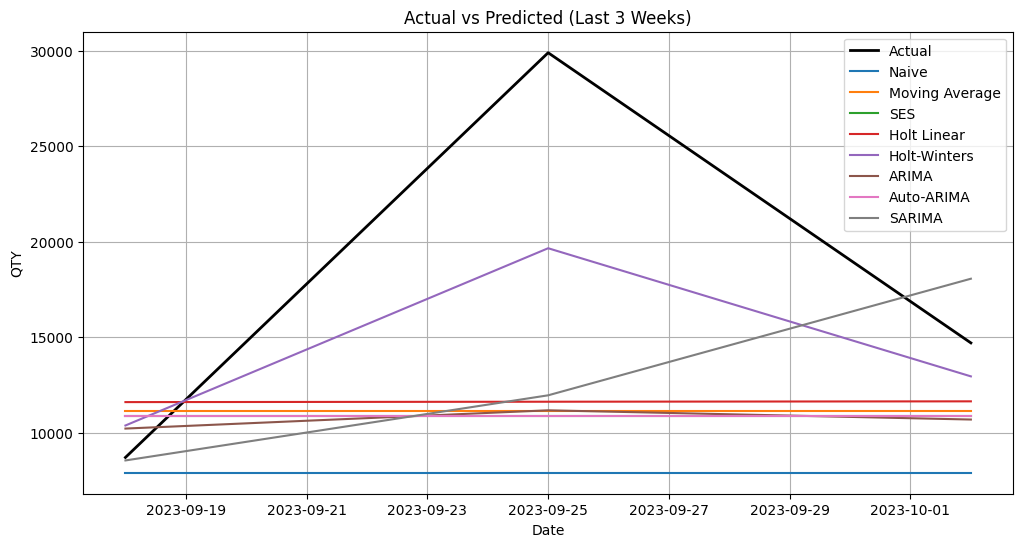

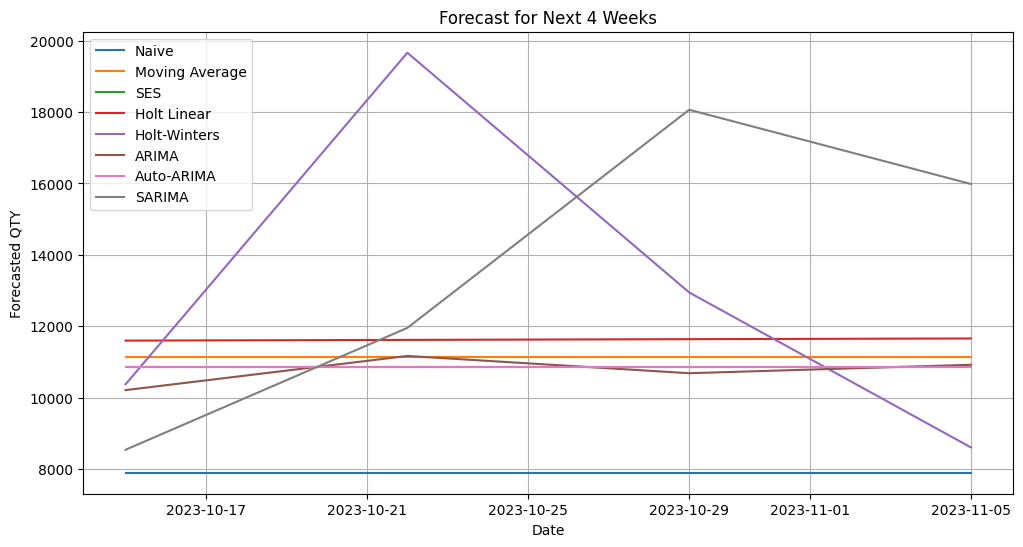

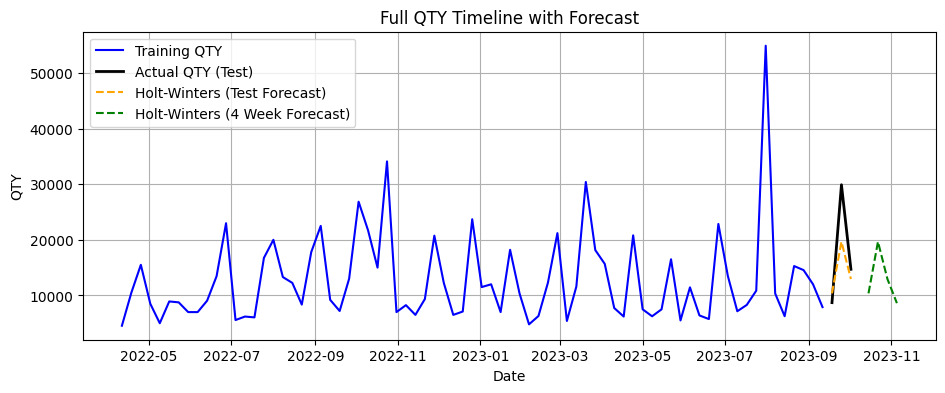


4-Week Forecast by Best Model (Holt-Winters):
2023-09-18    10374
2023-09-25    19659
2023-10-02    12947
2023-10-09     8607
Freq: W-MON, dtype: int32


In [59]:
# 1️⃣ PLOT: Actual vs Predicted for Last 3 Weeks
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, actual_test, label='Actual', color='black', linewidth=2)
for model, forecast in test_forecasts.items():
    plt.plot(y_test.index, forecast, label=model)
plt.title("Actual vs Predicted (Last 3 Weeks)")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ PLOT: Forecast for Next 4 Weeks (Original Scale)
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(weeks=1), periods=4, freq='W')
plt.figure(figsize=(12, 6))
for model, forecast in forecast_4weeks.items():
    plt.plot(future_dates, forecast, label=model)
plt.title("Forecast for Next 4 Weeks")
plt.xlabel("Date")
plt.ylabel("Forecasted QTY")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ PLOT: Complete Timeline (Train + Test + Forecast)
plt.figure(figsize=(11, 4))
plt.plot(y_train.index, actual_train, label='Training QTY', color='blue')
plt.plot(y_test.index, actual_test, label='Actual QTY (Test)', color='black', linewidth=2)
if best_method in test_forecasts:
    plt.plot(y_test.index, test_forecasts[best_method], '--', label=f'{best_method} (Test Forecast)', color='orange')
if best_method in forecast_4weeks:
    plt.plot(future_dates, forecast_4weeks[best_method], '--', label=f'{best_method} (4 Week Forecast)', color='green')
plt.title("Full QTY Timeline with Forecast")
plt.xlabel("Date")
plt.ylabel("QTY")
plt.legend()
plt.grid(True)
plt.show()

# Print only best forecast
if best_method and best_method in forecast_4weeks:
    print(f"\n4-Week Forecast by Best Model ({best_method}):")
    print(np.round(forecast_4weeks[best_method], 2))
else:
    print("\nNo valid forecast available from models with MAPE < 10%")

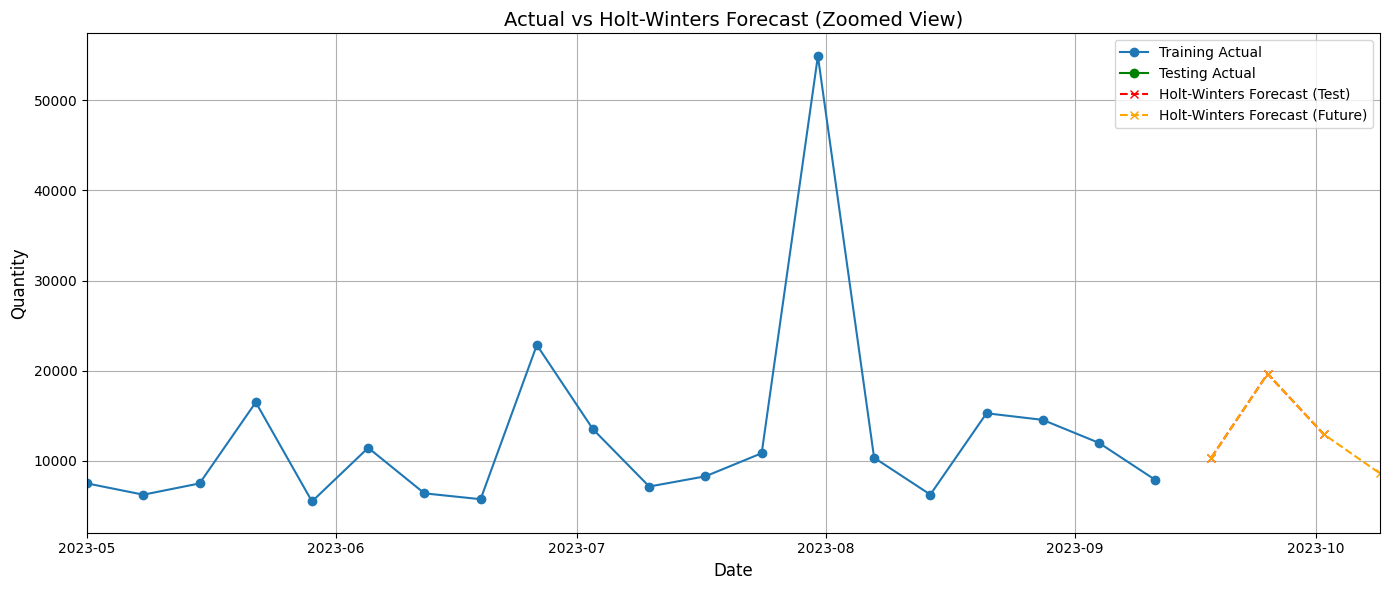

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot training actual
plt.plot(y_train.index, np.expm1(y_train_log), label='Training Actual', marker='o')

# Plot testing actual
plt.plot(y_test.index, np.expm1(y_test), label='Testing Actual', marker='o', color='green')

# Plot Holt-Winters forecast on test set
plt.plot(y_test.index, test_forecasts['Holt-Winters'], label='Holt-Winters Forecast (Test)', linestyle='--', marker='x', color='red')

# Plot Holt-Winters forecast on future
plt.plot(forecast_4weeks['Holt-Winters'].index, forecast_4weeks['Holt-Winters'].values, label='Holt-Winters Forecast (Future)', linestyle='--', marker='x', color='orange')

# Labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs Holt-Winters Forecast (Zoomed View)', fontsize=14)
plt.legend()
plt.grid(True)

# Zoom into the last few months
plt.xlim(y_train.index[-20], forecast_4weeks['Holt-Winters'].index[-1])

plt.tight_layout()
plt.show()
